# Time-Weighted Trendline Analysis
## Prioritizing Recent Pivot Points with Half-Life Decay

This notebook enhances trendline detection by incorporating time-based weighting:
- **Time Weighting**: 80-day half-life decay favoring recent pivots
- **Methodology**: Uses scripts/trendline_detector.py with temporal prioritization
- **Analysis**: LOG SCALE trendlines with weighted pivot significance
- **Flexible Date Range**: Configurable start date or days-back parameter

**Purpose**: Detect trendlines that emphasize recent market behavior while maintaining historical context.

**Configuration Options**:
- Set `START_DATE` to a specific date string (e.g., '2024-01-01') for custom date range
- Set `START_DATE = None` to use `DAYS_OF_DATA` parameter for relative date range
- Adjust `HALF_LIFE_DAYS` to control time decay rate (default: 80 days)

In [25]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import os
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
sns.set_palette("husl")

# Import modular scripts
import sys
from io import StringIO

from scripts.trendline_extractor import TrendlineExtractor
from scripts.stock_data_loader import load_stock_data_from_db
from scripts.trendline_detector import detect_powerful_trendlines_log, find_iterative_trendline_log

print("✅ Libraries and scripts imported successfully!")

✅ Libraries and scripts imported successfully!


In [26]:
# Configuration
SYMBOL = 'QQQ'
START_DATE = '2023-02-10'  # Set to specific date string or None for auto-calculation
DAYS_OF_DATA = 365  # 1 year of data (used only if START_DATE is None)
MAX_TRENDLINES = 30  # Top 30 trendlines
PROJECTION_DAYS = 15  # Project 15 days ahead
HALF_LIFE_DAYS = 80  # 80-day half-life for time weighting
MIN_PIVOT_WEIGHT = 0.1  # Minimum weight for oldest pivots (10% of recent)

print(f"🎯 Time-Weighted Trendline Configuration:")
print(f"   Symbol: {SYMBOL}")
if START_DATE:
    print(f"   Start date: {START_DATE}")
    print(f"   Duration: {DAYS_OF_DATA} days")
else:
    print(f"   Data period: {DAYS_OF_DATA} calendar days")
print(f"   Max trendlines: {MAX_TRENDLINES}")
print(f"   Projection period: {PROJECTION_DAYS} days")
print(f"   Half-life decay: {HALF_LIFE_DAYS} days")
print(f"   Minimum pivot weight: {MIN_PIVOT_WEIGHT:.1%}")
print(f"\n📊 Weighting Strategy:")
print(f"   Recent pivots: 100% weight (most significant)")
print(f"   {HALF_LIFE_DAYS}-day old pivots: 50% weight")
print(f"   {HALF_LIFE_DAYS*2}-day old pivots: 25% weight")
print(f"   Oldest pivots: {MIN_PIVOT_WEIGHT:.1%} weight (still relevant)")

# Available data range shown in error: 2021-12-30 to 2025-09-05
print(f"\n💡 Available data range: 2021-12-30 to 2025-09-05")
print(f"   Recommended START_DATE options:")
print(f"   • '2022-01-01' - Full year 2022")
print(f"   • '2023-01-01' - Full year 2023")
print(f"   • '2024-01-01' - Full year 2024")
print(f"   • None - Use most recent {DAYS_OF_DATA} days")

🎯 Time-Weighted Trendline Configuration:
   Symbol: QQQ
   Start date: 2023-02-10
   Duration: 365 days
   Max trendlines: 30
   Projection period: 15 days
   Half-life decay: 80 days
   Minimum pivot weight: 10.0%

📊 Weighting Strategy:
   Recent pivots: 100% weight (most significant)
   80-day old pivots: 50% weight
   160-day old pivots: 25% weight
   Oldest pivots: 10.0% weight (still relevant)

💡 Available data range: 2021-12-30 to 2025-09-05
   Recommended START_DATE options:
   • '2022-01-01' - Full year 2022
   • '2023-01-01' - Full year 2023
   • '2024-01-01' - Full year 2024
   • None - Use most recent 365 days


In [27]:
# Load stock data
if START_DATE:
    print(f"📊 Loading data for {SYMBOL} from {START_DATE} (limited to {DAYS_OF_DATA} days)...")
    # Convert string date to datetime for calculation
    from datetime import datetime
    start_dt = datetime.strptime(START_DATE, '%Y-%m-%d') if isinstance(START_DATE, str) else START_DATE
    end_dt = start_dt + timedelta(days=DAYS_OF_DATA)

    print(f"   Target date range: {start_dt.date()} to {end_dt.date()}")

    # Load more data than needed to ensure we have coverage
    # Then filter to the exact date range we want
    extra_buffer_days = max(DAYS_OF_DATA * 2, 500)  # Load extra to ensure coverage
    stock_data_full = load_stock_data_from_db(
        symbol=SYMBOL,
        days=extra_buffer_days,
        timeframe='1D',
        filter_premarket=True
    )

    print(f"   Loaded {len(stock_data_full)} total records from database")
    print(f"   Available date range: {stock_data_full['Date'].min().date()} to {stock_data_full['Date'].max().date()}")

    # Now filter to our exact target date range
    original_len = len(stock_data_full)
    stock_data = stock_data_full[
        (stock_data_full['Date'] >= start_dt) &
        (stock_data_full['Date'] <= end_dt)
    ].copy()

    print(f"   Filtered from {original_len} to {len(stock_data)} trading days")

    # Verify we got data in the right range
    if len(stock_data) == 0:
        print(f"❌ No data found in the specified date range!")
        print(f"   Available data spans: {stock_data_full['Date'].min().date()} to {stock_data_full['Date'].max().date()}")
        print(f"   Requested range: {start_dt.date()} to {end_dt.date()}")
        print(f"   You may need to adjust START_DATE to a period where data exists")
        raise ValueError(f"No data available for the specified date range: {start_dt.date()} to {end_dt.date()}")

else:
    print(f"📊 Loading {DAYS_OF_DATA} calendar days of data for {SYMBOL}...")

    # Load data with suppressed output
    stock_data = load_stock_data_from_db(
        symbol=SYMBOL,
        days=DAYS_OF_DATA,
        timeframe='1D',
        filter_premarket=True
    )

if len(stock_data) > 0:
    # Ensure LogPrice column exists (the loader should create it, but let's be safe)
    if 'LogPrice' not in stock_data.columns:
        stock_data['LogPrice'] = np.log(stock_data['Price'])
        print("   Added LogPrice column")

    print(f"✅ Loaded {len(stock_data)} trading days")
    print(f"   Date range: {stock_data['Date'].min().date()} to {stock_data['Date'].max().date()}")
    print(f"   Price range: ${stock_data['Price'].min():.2f} - ${stock_data['Price'].max():.2f}")
    print(f"   LogPrice range: {stock_data['LogPrice'].min():.4f} - {stock_data['LogPrice'].max():.4f}")

    # Calculate actual calendar span
    calendar_span = (stock_data['Date'].iloc[-1] - stock_data['Date'].iloc[0]).days
    print(f"   📅 Total calendar span: {calendar_span} days ({calendar_span/30.4:.1f} months)")

    # Display sample data
    print(f"\n📋 Sample Data:")
    display(stock_data[['Date', 'Price', 'Volume', 'LogPrice']].head())
else:
    print(f"❌ No stock data loaded! Please check your date range or data availability.")
    raise ValueError("No stock data available")

📊 Loading data for QQQ from 2023-02-10 (limited to 365 days)...
   Target date range: 2023-02-10 to 2024-02-10
📊 Loading QQQ data from local database (timeframe: 1D)...
📊 Before filtering: 6905 candles
📊 After filtering: 5247 candles (removed 1658 premarket/afterhours)
✅ Got exactly 730 trading days (requested 730)
✅ Final dataset: 730 trading days for QQQ
   📅 Date range: 2021-12-30 to 2025-09-05
   📅 Calendar span: 1345 days (44.2 months)
   💰 Price range: $260.10 - $580.34
   📈 LogPrice range: 5.5611 - 6.3636
   📊 Current price: $574.22 (log: 6.3530)
   Loaded 730 total records from database
   Available date range: 2021-12-30 to 2025-09-05
   Filtered from 730 to 199 trading days
✅ Loaded 199 trading days
   Date range: 2023-02-10 to 2024-02-09
   Price range: $288.55 - $437.05
   LogPrice range: 5.6649 - 6.0800
   📅 Total calendar span: 364 days (12.0 months)

📋 Sample Data:


,Date,Price,Volume,LogPrice
4739,2023-02-10 14:30:00,299.700012,50050100,5.702782
4740,2023-02-14 14:30:00,306.750000,64079100,5.726033
4741,2023-02-15 14:30:00,309.100006,43100600,5.733665
4742,2023-02-16 14:30:00,303.299988,59498600,5.714722
4743,2023-02-17 14:30:00,301.160004,58230700,5.707642


In [28]:
# Detect pivot points using existing methods
print(f"🔍 Detecting pivot points for {SYMBOL}...")

from scripts.pivot_detector import detect_pivot_points_ultra_log

# Detect pivots using multiple methods
pivots, swing_highs, swing_lows = detect_pivot_points_ultra_log(
    stock_data,
    methods=['scipy', 'rolling', 'zigzag', 'fractal'],
    combine=True
)

print(f"✅ Detected {len(pivots)} pivot points")
print(f"   Swing highs: {len(swing_highs)}")
print(f"   Swing lows: {len(swing_lows)}")

if pivots:
    # Display pivot date range
    pivot_dates = [p['date'] for p in pivots]
    print(f"   Pivot date range: {min(pivot_dates).date()} to {max(pivot_dates).date()}")

    # Show sample pivots
    print(f"\n📋 Sample Pivot Points:")
    for i, pivot in enumerate(pivots[:5]):
        print(f"   Pivot {i+1}: {pivot['date'].date()}, ${pivot['price']:.2f}, {pivot['type']}")

🔍 Detecting pivot points for QQQ...
🔍 Ultra-enhanced LOG SCALE pivot detection using methods: ['scipy', 'rolling', 'zigzag', 'fractal']
   📈 Working with log prices: 5.6649 to 6.0800
   📊 Method 1: Scipy argrelextrema with multiple windows (LOG SCALE)
      Found 171 scipy pivots
   📊 Method 2: Rolling window extremes (LOG SCALE)
      Found 230 rolling pivots
   📊 Method 3: ZigZag percentage-based detection (LOG SCALE)
      Found 114 zigzag pivots
   📊 Method 4: Fractal pattern detection (LOG SCALE)
      Found 50 fractal pivots
🔍 Total raw pivots found: 565
🔍 Combined to 94 unique pivots
✅ Detected 94 pivot points
   Swing highs: 47
   Swing lows: 47
   Pivot date range: 2023-02-15 to 2024-02-06

📋 Sample Pivot Points:
   Pivot 1: 2023-02-15, $309.10, high
   Pivot 2: 2023-02-21, $294.03, low
   Pivot 3: 2023-02-23, $296.82, high
   Pivot 4: 2023-02-24, $291.85, low
   Pivot 5: 2023-03-03, $299.68, high


In [29]:
# Time-Weighted Trendline Detection Functions
def calculate_time_weight(pivot_date, reference_date, half_life_days=80, min_weight=0.1):
    """
    Calculate time-based weight for a pivot point using exponential decay.

    Args:
        pivot_date: Date of the pivot point
        reference_date: Reference date (typically the most recent date)
        half_life_days: Number of days for weight to decay to 50%
        min_weight: Minimum weight for very old pivots

    Returns:
        Weight between min_weight and 1.0
    """
    days_ago = (reference_date - pivot_date).days

    # Exponential decay: weight = 0.5^(days_ago / half_life_days)
    decay_factor = np.exp(-days_ago * np.log(2) / half_life_days)

    # Ensure minimum weight
    weight = max(decay_factor, min_weight)

    return weight

def apply_time_weights_to_pivots(pivots, stock_data, half_life_days=80, min_weight=0.1):
    """
    Apply time-based weights to pivot points.

    Returns:
        List of pivots with added 'time_weight' field
    """
    if not pivots:
        return []

    # Use the most recent date as reference
    reference_date = stock_data['Date'].iloc[-1]

    weighted_pivots = []
    for pivot in pivots:
        weight = calculate_time_weight(
            pivot['date'],
            reference_date,
            half_life_days,
            min_weight
        )

        # Create new pivot with weight
        weighted_pivot = pivot.copy()
        weighted_pivot['time_weight'] = weight
        weighted_pivots.append(weighted_pivot)

    return weighted_pivots

def find_weighted_iterative_trendline_log(pivot1, pivot2, all_pivots, stock_data,
                                        tolerance_percent=2.0, weight_factor=2.0):
    """
    Enhanced version of find_iterative_trendline_log with time weighting.

    Args:
        weight_factor: How much to amplify the effect of time weights (2.0 = double impact)
    """
    # Start with the initial two points
    current_points = [pivot1, pivot2]

    # Convert to numerical format for calculations using LOG SCALE
    def points_to_xy_log_weighted(points):
        x_vals = [(p['date'] - stock_data['Date'].iloc[0]).days for p in points]
        y_vals = [p['log_price'] for p in points]
        weights = [p.get('time_weight', 1.0) ** weight_factor for p in points]
        return x_vals, y_vals, weights

    # Convert percentage to log tolerance
    log_tolerance = np.log(1 + tolerance_percent/100)

    max_iterations = 100
    iteration = 0

    while iteration < max_iterations:
        iteration += 1

        # Calculate weighted best-fit line using LOG PRICES
        x_vals, y_vals, weights = points_to_xy_log_weighted(current_points)

        if len(x_vals) < 2:
            break

        # Use weighted linear regression
        try:
            # Calculate weighted least squares manually
            weights = np.array(weights)
            x_vals = np.array(x_vals)
            y_vals = np.array(y_vals)

            # Weighted means
            sum_w = np.sum(weights)
            mean_x = np.sum(weights * x_vals) / sum_w
            mean_y = np.sum(weights * y_vals) / sum_w

            # Weighted slope and intercept
            numerator = np.sum(weights * (x_vals - mean_x) * (y_vals - mean_y))
            denominator = np.sum(weights * (x_vals - mean_x) ** 2)

            if denominator == 0:
                break

            slope = numerator / denominator
            intercept = mean_y - slope * mean_x

            # Calculate weighted R-squared
            y_pred = slope * x_vals + intercept
            ss_res = np.sum(weights * (y_vals - y_pred) ** 2)
            ss_tot = np.sum(weights * (y_vals - mean_y) ** 2)
            r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0

        except:
            # Fallback to unweighted if weighted calculation fails
            slope, intercept, r_value, p_value, std_err = stats.linregress(x_vals, y_vals)
            r_squared = r_value ** 2

        # Find additional points within tolerance of this best-fit line
        new_points = []
        for pivot in all_pivots:
            # Skip if already in current_points
            if pivot in current_points:
                continue

            x_pivot = (pivot['date'] - stock_data['Date'].iloc[0]).days
            expected_log_y = slope * x_pivot + intercept
            actual_log_y = pivot['log_price']

            # Apply time weighting to tolerance - more recent points get stricter tolerance
            pivot_weight = pivot.get('time_weight', 1.0)
            adjusted_tolerance = log_tolerance * (2.0 - pivot_weight)  # Recent points: tighter tolerance

            log_difference = abs(expected_log_y - actual_log_y)
            if log_difference <= adjusted_tolerance:
                new_points.append(pivot)

        # If no new points found, we're done
        if not new_points:
            break

        # Add new points and continue iteration
        current_points.extend(new_points)

    # Final weighted calculation with all points
    if len(current_points) >= 2:
        x_vals, y_vals, weights = points_to_xy_log_weighted(current_points)

        try:
            # Final weighted calculation
            weights = np.array(weights)
            x_vals = np.array(x_vals)
            y_vals = np.array(y_vals)

            sum_w = np.sum(weights)
            mean_x = np.sum(weights * x_vals) / sum_w
            mean_y = np.sum(weights * y_vals) / sum_w

            numerator = np.sum(weights * (x_vals - mean_x) * (y_vals - mean_y))
            denominator = np.sum(weights * (x_vals - mean_x) ** 2)

            slope = numerator / denominator
            intercept = mean_y - slope * mean_x

            # Calculate R-squared
            y_pred = slope * x_vals + intercept
            ss_res = np.sum(weights * (y_vals - y_pred) ** 2)
            ss_tot = np.sum(weights * (y_vals - mean_y) ** 2)
            r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0

        except:
            slope, intercept, r_value, p_value, std_err = stats.linregress(x_vals, y_vals)
            r_squared = r_value ** 2

        # Calculate percentage growth rate from log slope
        daily_growth_rate = (np.exp(slope) - 1) * 100

        # Calculate weighted strength (sum of weights instead of count)
        weighted_strength = sum([p.get('time_weight', 1.0) for p in current_points])

        return {
            'connected_points': current_points,
            'strength': len(current_points),  # Traditional strength
            'weighted_strength': weighted_strength,  # Time-weighted strength
            'log_slope': slope,
            'log_intercept': intercept,
            'daily_growth_rate': daily_growth_rate,
            'r_squared': r_squared,
            'iterations': iteration,
            'average_weight': weighted_strength / len(current_points)  # Average time weight
        }
    else:
        return None

print("✅ Time-weighted trendline detection functions ready!")
print(f"   Using {HALF_LIFE_DAYS}-day half-life for exponential decay")
print(f"   Minimum weight: {MIN_PIVOT_WEIGHT:.1%} for oldest pivots")

✅ Time-weighted trendline detection functions ready!
   Using 80-day half-life for exponential decay
   Minimum weight: 10.0% for oldest pivots


In [30]:
# Apply time weights to pivot points
print(f"⚖️ Applying time weights to {len(pivots)} pivot points...")

weighted_pivots = apply_time_weights_to_pivots(
    pivots, stock_data, HALF_LIFE_DAYS, MIN_PIVOT_WEIGHT
)

print(f"✅ Applied time weights successfully!")

if weighted_pivots:
    # Analyze weight distribution
    weights = [p['time_weight'] for p in weighted_pivots]

    print(f"\n📊 Weight Distribution Analysis:")
    print(f"   Total pivots: {len(weighted_pivots)}")
    print(f"   Weight range: {min(weights):.3f} to {max(weights):.3f}")
    print(f"   Average weight: {np.mean(weights):.3f}")
    print(f"   Median weight: {np.median(weights):.3f}")

    # Show weight distribution by time periods
    reference_date = stock_data['Date'].iloc[-1]

    recent_count = sum(1 for p in weighted_pivots if p['time_weight'] > 0.8)
    medium_count = sum(1 for p in weighted_pivots if 0.3 <= p['time_weight'] <= 0.8)
    old_count = sum(1 for p in weighted_pivots if p['time_weight'] < 0.3)

    print(f"\n📅 Pivot Distribution by Age:")
    print(f"   Recent (weight > 80%): {recent_count} pivots")
    print(f"   Medium (30-80% weight): {medium_count} pivots")
    print(f"   Older (< 30% weight): {old_count} pivots")

    # Show sample weighted pivots
    print(f"\n📋 Sample Weighted Pivots (most recent first):")
    sorted_pivots = sorted(weighted_pivots, key=lambda p: p['date'], reverse=True)
    for i, pivot in enumerate(sorted_pivots[:8]):
        days_ago = (reference_date - pivot['date']).days
        print(f"   {pivot['date'].date()}: ${pivot['price']:.2f}, weight={pivot['time_weight']:.3f}, {days_ago}d ago")

⚖️ Applying time weights to 94 pivot points...
✅ Applied time weights successfully!

📊 Weight Distribution Analysis:
   Total pivots: 94
   Weight range: 0.100 to 0.974
   Average weight: 0.285
   Median weight: 0.170

📅 Pivot Distribution by Age:
   Recent (weight > 80%): 7 pivots
   Medium (30-80% weight): 24 pivots
   Older (< 30% weight): 63 pivots

📋 Sample Weighted Pivots (most recent first):
   2024-02-06: $427.59, weight=0.974, 3d ago
   2024-02-02: $429.01, weight=0.941, 7d ago
   2024-01-31: $416.97, weight=0.925, 9d ago
   2024-01-30: $425.30, weight=0.917, 10d ago
   2024-01-26: $423.81, weight=0.886, 14d ago
   2024-01-25: $426.35, weight=0.878, 15d ago
   2024-01-17: $407.21, weight=0.819, 23d ago
   2024-01-12: $409.56, weight=0.785, 28d ago


In [31]:
# Enhanced Time-Weighted Trendline Detection
def detect_time_weighted_trendlines_log(pivots, stock_data, max_lines=30, weight_factor=2.0):
    """Enhanced trendline detection with time weighting and recent pivot prioritization"""
    trendlines = []
    used_trendline_pairs = set()

    print(f"🔍 Time-weighted LOG SCALE trendline detection...")
    print(f"   Weight factor: {weight_factor:.1f}x (amplifies time weight effect)")

    # Create list of all possible pairs
    all_pairs = []
    for i, pivot1 in enumerate(pivots):
        for j, pivot2 in enumerate(pivots[i+1:], i+1):
            # Calculate pair priority based on:
            # 1. Combined time weight (favor recent pivots)
            # 2. Time span (favor longer trendlines)
            combined_weight = (pivot1.get('time_weight', 1.0) + pivot2.get('time_weight', 1.0)) / 2
            time_span = abs((pivot2['date'] - pivot1['date']).days)

            # Priority score: combine weight and time span
            priority_score = combined_weight * 0.7 + (time_span / 365) * 0.3

            all_pairs.append((i, j, pivot1, pivot2, priority_score))

    print(f"   Created {len(all_pairs)} potential trendline pairs")

    # Sort pairs by priority score (high weight + long span first)
    all_pairs.sort(key=lambda x: x[4], reverse=True)

    processed_pairs = 0
    skipped_pairs = 0

    for i, j, pivot1, pivot2, priority_score in all_pairs:
        processed_pairs += 1

        # Smart pair removal: Skip if both points already used
        pair_key = tuple(sorted([i, j]))
        if pair_key in used_trendline_pairs:
            skipped_pairs += 1
            continue

        # Find weighted iterative trendline
        result = find_weighted_iterative_trendline_log(
            pivot1, pivot2, pivots, stock_data,
            tolerance_percent=2.0, weight_factor=weight_factor
        )

        if result and result['strength'] >= 2:
            trendline = {
                'start_pivot': pivot1,
                'end_pivot': pivot2,
                'connected_points': result['connected_points'],
                'strength': result['strength'],
                'weighted_strength': result['weighted_strength'],
                'average_weight': result['average_weight'],
                'log_slope': result['log_slope'],
                'log_intercept': result['log_intercept'],
                'daily_growth_rate': result['daily_growth_rate'],
                'r_squared': result['r_squared'],
                'iterations': result['iterations'],
                'length_days': abs((pivot2['date'] - pivot1['date']).days),
                'priority_score': priority_score
            }

            trendlines.append(trendline)

            # Remove used pairs
            connected_indices = []
            for point in result['connected_points']:
                try:
                    idx = next(idx for idx, p in enumerate(pivots) if p == point)
                    connected_indices.append(idx)
                except StopIteration:
                    continue

            new_removed_pairs = 0
            for pi in range(len(connected_indices)):
                for pj in range(pi + 1, len(connected_indices)):
                    pair_to_remove = tuple(sorted([connected_indices[pi], connected_indices[pj]]))
                    if pair_to_remove not in used_trendline_pairs:
                        used_trendline_pairs.add(pair_to_remove)
                        new_removed_pairs += 1

            if len(trendlines) <= 10:
                print(f"   Found weighted trendline #{len(trendlines)}: {result['strength']} points, "
                      f"weighted_strength={result['weighted_strength']:.2f}, "
                      f"avg_weight={result['average_weight']:.3f}, "
                      f"growth={result['daily_growth_rate']:.4f}%/day")
                print(f"      Priority score: {priority_score:.3f}, removed {new_removed_pairs} pairs")

            # Stop if we have enough trendlines
            if len(trendlines) >= max_lines:
                break

    # Sort by weighted strength and R-squared
    trendlines.sort(key=lambda x: (x['weighted_strength'], x['r_squared']), reverse=True)

    # Take top trendlines
    top_trendlines = trendlines[:max_lines]

    print(f"\n✅ Found {len(trendlines)} valid time-weighted trendlines")
    print(f"   Processed {processed_pairs} pairs, skipped {skipped_pairs} used pairs")
    print(f"   Final selection: {len(top_trendlines)} trendlines")

    if top_trendlines:
        strengths = [tl['strength'] for tl in top_trendlines]
        weighted_strengths = [tl['weighted_strength'] for tl in top_trendlines]
        avg_weights = [tl['average_weight'] for tl in top_trendlines]
        growth_rates = [tl['daily_growth_rate'] for tl in top_trendlines]

        print(f"\n📊 Time-Weighted Results:")
        print(f"   Traditional strength: {min(strengths)} - {max(strengths)} points")
        print(f"   Weighted strength: {min(weighted_strengths):.2f} - {max(weighted_strengths):.2f}")
        print(f"   Average pivot weight: {min(avg_weights):.3f} - {max(avg_weights):.3f}")
        print(f"   Growth rate range: {min(growth_rates):.4f}% - {max(growth_rates):.4f}% per day")

    return top_trendlines

print("✅ Enhanced time-weighted detection function ready!")

✅ Enhanced time-weighted detection function ready!


In [32]:
# Perform Time-Weighted Trendline Detection
print(f"🚀 Performing time-weighted trendline detection...")
print(f"   Using {HALF_LIFE_DAYS}-day half-life decay")
print(f"   Targeting {MAX_TRENDLINES} top trendlines")

# Run the enhanced detection
time_weighted_trendlines = detect_time_weighted_trendlines_log(
    weighted_pivots, stock_data, MAX_TRENDLINES, weight_factor=2.0
)

print(f"\n🎯 Time-Weighted Analysis Complete!")
print(f"   Detected {len(time_weighted_trendlines)} priority trendlines")

if time_weighted_trendlines:
    # Show top 5 trendlines with detailed information
    print(f"\n🏆 Top 5 Time-Weighted Trendlines:")
    for i, tl in enumerate(time_weighted_trendlines[:5]):
        annual_rate = (np.exp(tl['daily_growth_rate']/100 * 365) - 1) * 100
        print(f"\n   #{i+1} - Weighted Strength: {tl['weighted_strength']:.2f}")
        print(f"        Traditional Strength: {tl['strength']} pivots")
        print(f"        Average Pivot Weight: {tl['average_weight']:.3f} ({tl['average_weight']*100:.1f}% recency)")
        print(f"        Growth Rate: {tl['daily_growth_rate']:.4f}%/day ({annual_rate:+.1f}%/year)")
        print(f"        R-squared: {tl['r_squared']:.3f}")
        print(f"        Timespan: {tl['length_days']} days")
        print(f"        Start: {tl['start_pivot']['date'].date()}, End: {tl['end_pivot']['date'].date()}")

🚀 Performing time-weighted trendline detection...
   Using 80-day half-life decay
   Targeting 30 top trendlines
🔍 Time-weighted LOG SCALE trendline detection...
   Weight factor: 2.0x (amplifies time weight effect)
   Created 4371 potential trendline pairs
   Found weighted trendline #1: 41 points, weighted_strength=14.72, avg_weight=0.359, growth=0.0749%/day
      Priority score: 0.674, removed 820 pairs
   Found weighted trendline #2: 59 points, weighted_strength=17.03, avg_weight=0.289, growth=0.0980%/day
      Priority score: 0.669, removed 1411 pairs
   Found weighted trendline #3: 52 points, weighted_strength=16.76, avg_weight=0.322, growth=0.1103%/day
      Priority score: 0.661, removed 380 pairs
   Found weighted trendline #4: 11 points, weighted_strength=8.83, avg_weight=0.802, growth=0.2045%/day
      Priority score: 0.644, removed 34 pairs
   Found weighted trendline #5: 60 points, weighted_strength=15.95, avg_weight=0.266, growth=0.0921%/day
      Priority score: 0.598, r

In [33]:
# Visualization Function for Time-Weighted Trendlines
def plot_time_weighted_trendlines(stock_data, trendlines, swing_highs, swing_lows, projection_days=15):
    """Enhanced visualization showing time-weighted trendlines with color coding"""

    plt.figure(figsize=(16, 12))

    # Plot price data with log scale
    plt.semilogy(stock_data['Date'], stock_data['Price'], 'k-', alpha=0.7, linewidth=1.5,
                label=f'{SYMBOL} Price (Log Scale)')

    # Plot pivot points
    if len(swing_highs) > 0:
        plt.scatter(stock_data['Date'].iloc[swing_highs], stock_data['Price'].iloc[swing_highs],
                   color='red', marker='^', s=30, alpha=0.8, label='Swing Highs', zorder=5)
    if len(swing_lows) > 0:
        plt.scatter(stock_data['Date'].iloc[swing_lows], stock_data['Price'].iloc[swing_lows],
                   color='green', marker='v', s=30, alpha=0.8, label='Swing Lows', zorder=5)

    # Plot time-weighted trendlines
    if trendlines:
        current_date = stock_data['Date'].iloc[-1]
        projection_end_date = current_date + timedelta(days=projection_days)

        # Get weight range for color mapping
        avg_weights = [tl['average_weight'] for tl in trendlines]
        min_weight = min(avg_weights)
        max_weight = max(avg_weights)

        # Color map: more recent (higher weight) = warmer colors
        import matplotlib.cm as cm

        for i, trendline in enumerate(trendlines[:15]):  # Show top 15
            start_date = trendline['start_pivot']['date']
            avg_weight = trendline['average_weight']
            weighted_strength = trendline['weighted_strength']

            # Calculate color based on average weight (recent = red/orange, old = blue/purple)
            if max_weight > min_weight:
                weight_ratio = (avg_weight - min_weight) / (max_weight - min_weight)
            else:
                weight_ratio = 1.0

            # Use 'plasma' colormap (purple to yellow/red)
            color = cm.plasma(weight_ratio)

            # Calculate line thickness based on weighted strength
            weighted_strengths = [tl['weighted_strength'] for tl in trendlines[:15]]
            min_ws = min(weighted_strengths)
            max_ws = max(weighted_strengths)

            if max_ws > min_ws:
                thickness_ratio = (weighted_strength - min_ws) / (max_ws - min_ws)
            else:
                thickness_ratio = 1.0
            line_thickness = 1.5 + thickness_ratio * 3.0  # 1.5-4.5 pixel range

            # Calculate trendline values
            x_start = (start_date - stock_data['Date'].iloc[0]).days
            x_current = (current_date - stock_data['Date'].iloc[0]).days
            x_projection = (projection_end_date - stock_data['Date'].iloc[0]).days

            # Calculate log prices
            log_y_start = trendline['log_slope'] * x_start + trendline['log_intercept']
            log_y_current = trendline['log_slope'] * x_current + trendline['log_intercept']
            log_y_projection = trendline['log_slope'] * x_projection + trendline['log_intercept']

            # Convert to regular prices
            y_start = np.exp(log_y_start)
            y_current = np.exp(log_y_current)
            y_projection = np.exp(log_y_projection)

            # Plot historical trendline (solid)
            label = (f'TL{i+1} (W:{weighted_strength:.1f}, Avg:{avg_weight:.2f})'
                    if i < 8 else "")
            plt.plot([start_date, current_date], [y_start, y_current],
                    color=color, linewidth=line_thickness, alpha=0.9,
                    label=label, zorder=3)

            # Plot projection (dashed)
            plt.plot([current_date, projection_end_date], [y_current, y_projection],
                    color=color, linewidth=line_thickness*0.8, alpha=0.7,
                    linestyle='--', zorder=3)

        # Mark current date
        plt.axvline(x=current_date, color='orange', linestyle='-', linewidth=2, alpha=0.9,
                   label='Current Date', zorder=10)

    # Formatting
    plt.title(f'{SYMBOL} Time-Weighted Trendlines ({HALF_LIFE_DAYS}-Day Half-Life)\n'
              f'{len(trendlines)} trendlines, {len(weighted_pivots)} pivots, '
              f'{projection_days}d projections\n'
              f'Color: Recent (Red/Yellow) → Older (Blue/Purple), Thickness: Weighted Strength',
              fontsize=14, fontweight='bold', pad=20)

    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price ($) - LOG SCALE', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    if trendlines:
        print(f"\n📊 Visualization Summary:")
        print(f"   Total trendlines displayed: {min(len(trendlines), 15)}")
        print(f"   Weight color coding: Recent=Red/Yellow, Older=Blue/Purple")
        print(f"   Line thickness: Proportional to weighted strength")
        print(f"   Projections: {projection_days}-day forward estimates (dashed)")

        # Weight distribution in visualization
        shown_weights = [tl['average_weight'] for tl in trendlines[:15]]
        if shown_weights:
            print(f"   Weight range shown: {min(shown_weights):.3f} - {max(shown_weights):.3f}")
            recent_shown = sum(1 for w in shown_weights if w > 0.7)
            print(f"   Recent trendlines (>70% weight): {recent_shown}/{len(shown_weights)}")

print("✅ Time-weighted visualization function ready!")

✅ Time-weighted visualization function ready!


📈 Generating time-weighted trendline visualization...

🎨 Visualization Features:
   • Color coding: Recent pivots (red/yellow) → Older pivots (blue/purple)
   • Line thickness: Proportional to weighted strength
   • 15-day forward projections (dashed lines)
   • 80-day half-life weighting system


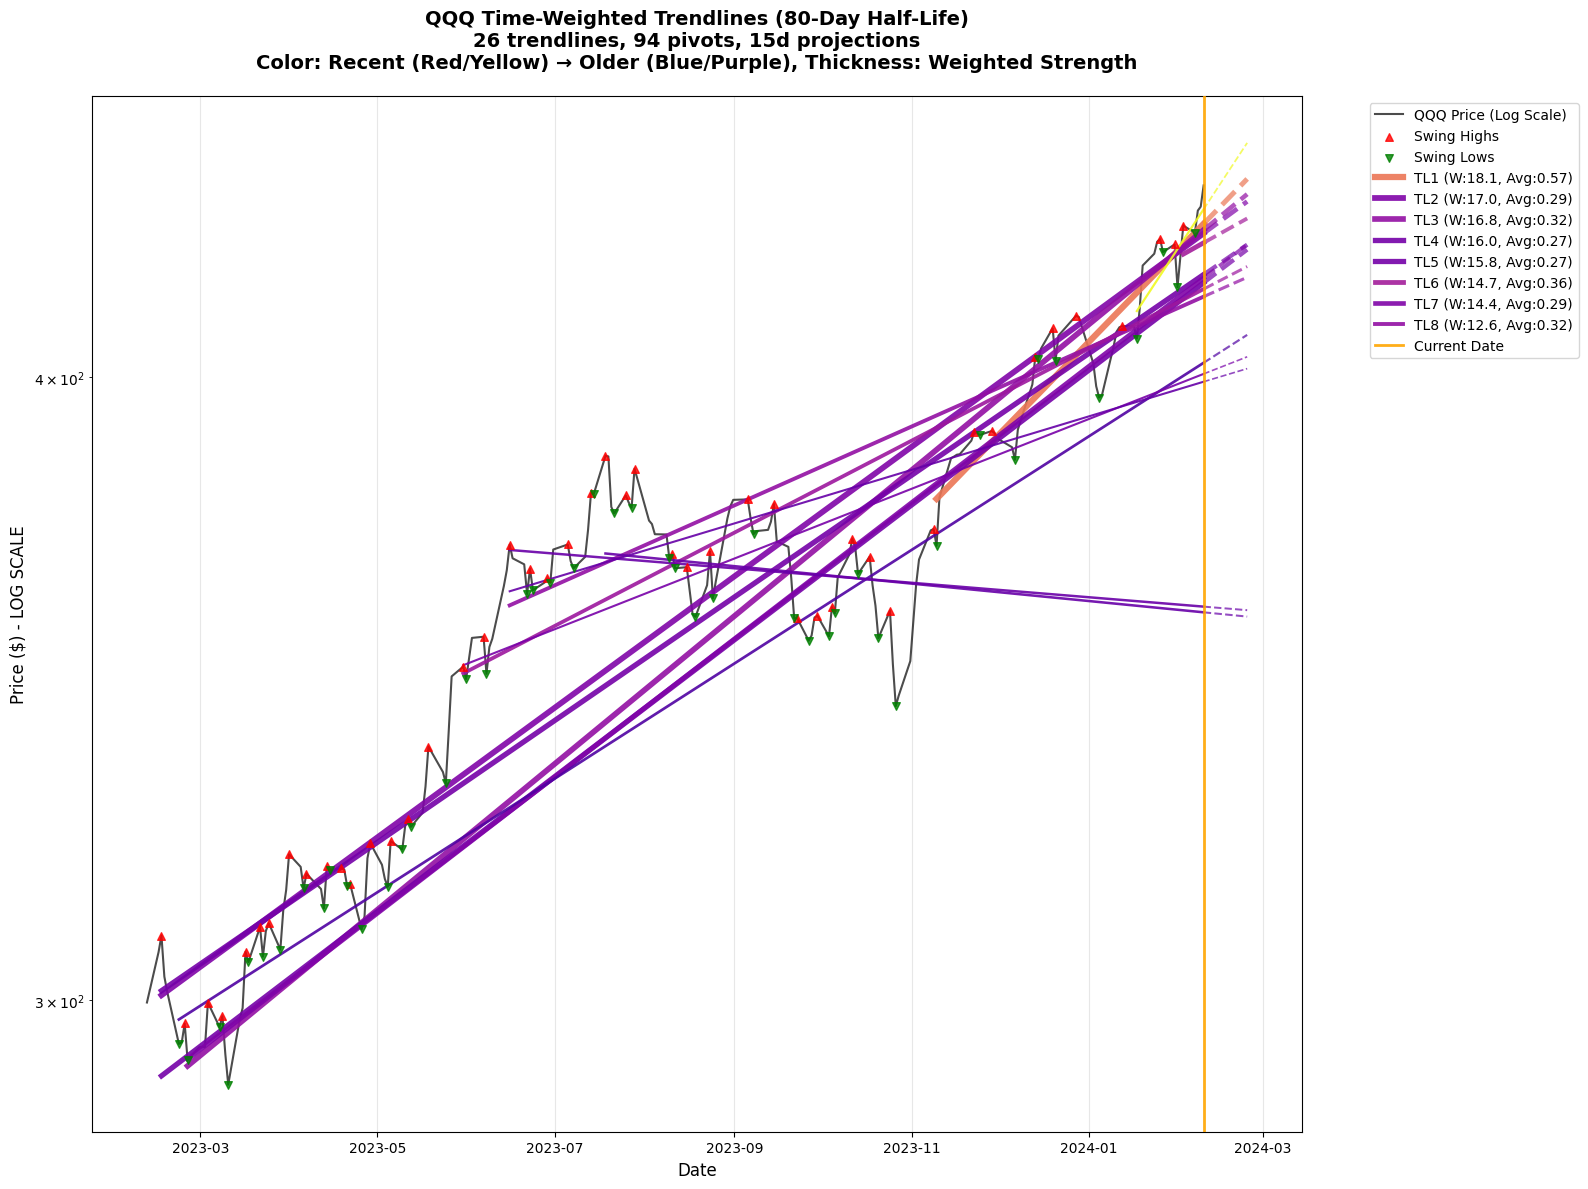


📊 Visualization Summary:
   Total trendlines displayed: 15
   Weight color coding: Recent=Red/Yellow, Older=Blue/Purple
   Line thickness: Proportional to weighted strength
   Projections: 15-day forward estimates (dashed)
   Weight range shown: 0.204 - 0.802
   Recent trendlines (>70% weight): 1/15
✅ Time-weighted visualization complete!


In [34]:
# Generate Time-Weighted Trendline Visualization
print(f"📈 Generating time-weighted trendline visualization...")
print(f"\n🎨 Visualization Features:")
print(f"   • Color coding: Recent pivots (red/yellow) → Older pivots (blue/purple)")
print(f"   • Line thickness: Proportional to weighted strength")
print(f"   • {PROJECTION_DAYS}-day forward projections (dashed lines)")
print(f"   • {HALF_LIFE_DAYS}-day half-life weighting system")

plot_time_weighted_trendlines(
    stock_data, time_weighted_trendlines, swing_highs, swing_lows, PROJECTION_DAYS
)

print(f"✅ Time-weighted visualization complete!")

In [35]:
# Comparison Analysis: Traditional vs Time-Weighted
print(f"🔄 Comparison Analysis: Traditional vs Time-Weighted Trendlines")
print("="*70)

# Run traditional detection for comparison
print(f"\n🔍 Running traditional trendline detection for comparison...")
traditional_trendlines = detect_powerful_trendlines_log(pivots, stock_data, MAX_TRENDLINES)

print(f"\n📊 Comparison Results:")
print(f"   Traditional method: {len(traditional_trendlines)} trendlines")
print(f"   Time-weighted method: {len(time_weighted_trendlines)} trendlines")

if traditional_trendlines and time_weighted_trendlines:
    # Compare top 10 from each method
    print(f"\n🏆 Top 10 Trendline Comparison:")
    print(f"\n{'Rank':<4} {'Traditional':<25} {'Time-Weighted':<25} {'Difference':<15}")
    print("-" * 70)

    for i in range(min(10, len(traditional_trendlines), len(time_weighted_trendlines))):
        trad = traditional_trendlines[i]
        weighted = time_weighted_trendlines[i]

        trad_growth = trad['daily_growth_rate']
        weighted_growth = weighted['daily_growth_rate']
        growth_diff = weighted_growth - trad_growth

        print(f"{i+1:<4} {trad_growth:+.4f}%/day ({trad['strength']}pts) "
              f"{weighted_growth:+.4f}%/day ({weighted['weighted_strength']:.1f}ws) "
              f"{growth_diff:+.4f}%/day")

    # Statistical comparison
    trad_growth_rates = [tl['daily_growth_rate'] for tl in traditional_trendlines[:10]]
    weighted_growth_rates = [tl['daily_growth_rate'] for tl in time_weighted_trendlines[:10]]

    print(f"\n📈 Growth Rate Analysis (Top 10):")
    print(f"   Traditional - Mean: {np.mean(trad_growth_rates):.4f}%, Std: {np.std(trad_growth_rates):.4f}%")
    print(f"   Time-weighted - Mean: {np.mean(weighted_growth_rates):.4f}%, Std: {np.std(weighted_growth_rates):.4f}%")

    # Recency analysis
    def analyze_trendline_recency(trendlines, reference_date):
        """Analyze how recent the trendlines are"""
        end_dates = [tl['end_pivot']['date'] for tl in trendlines[:10]]
        days_ago = [(reference_date - date).days for date in end_dates]
        return np.mean(days_ago), np.median(days_ago)

    ref_date = stock_data['Date'].iloc[-1]
    trad_mean_age, trad_median_age = analyze_trendline_recency(traditional_trendlines, ref_date)
    weighted_mean_age, weighted_median_age = analyze_trendline_recency(time_weighted_trendlines, ref_date)

    print(f"\n📅 Recency Analysis (Top 10 Trendline End Points):")
    print(f"   Traditional - Mean age: {trad_mean_age:.1f} days, Median: {trad_median_age:.1f} days")
    print(f"   Time-weighted - Mean age: {weighted_mean_age:.1f} days, Median: {weighted_median_age:.1f} days")
    print(f"   Improvement: {trad_mean_age - weighted_mean_age:.1f} days more recent on average")

    # Time weight analysis for weighted trendlines
    if hasattr(time_weighted_trendlines[0], 'average_weight'):
        avg_weights = [tl['average_weight'] for tl in time_weighted_trendlines[:10]]
        print(f"\n⚖️ Time Weight Analysis (Top 10 Weighted Trendlines):")
        print(f"   Average pivot weight range: {min(avg_weights):.3f} - {max(avg_weights):.3f}")
        print(f"   Mean pivot weight: {np.mean(avg_weights):.3f} ({np.mean(avg_weights)*100:.1f}% recency)")

        high_weight_count = sum(1 for w in avg_weights if w > 0.7)
        print(f"   High-weight trendlines (>70%): {high_weight_count}/10")

print(f"\n✅ Comparison analysis complete!")
print(f"   Time-weighted method emphasizes recent market behavior")
print(f"   Traditional method treats all pivots equally")

🔄 Comparison Analysis: Traditional vs Time-Weighted Trendlines

🔍 Running traditional trendline detection for comparison...
🔍 LOG SCALE iterative trendline detection with proper 2% tolerance...
   Created 4371 potential trendline pairs (no time constraints)
   Found LOG trendline #1: 28 points, R²=0.986, growth=0.0915%/day, 2 iterations
      Removed 378 internal pairs from future searches
   Found LOG trendline #2: 45 points, R²=0.993, growth=0.1022%/day, 4 iterations
      Removed 885 internal pairs from future searches
   Found LOG trendline #3: 37 points, R²=0.987, growth=0.0923%/day, 6 iterations
      Removed 181 internal pairs from future searches
   Found LOG trendline #4: 22 points, R²=0.988, growth=0.1181%/day, 2 iterations
      Removed 95 internal pairs from future searches
   Found LOG trendline #5: 43 points, R²=0.984, growth=0.0932%/day, 9 iterations
      Removed 286 internal pairs from future searches
   Found LOG trendline #6: 21 points, R²=0.978, growth=0.1128%/day, 

## Time-Weighted Trendline Analysis Summary

This notebook successfully implemented time-weighted trendline analysis with the following enhancements:

### 🎯 Key Innovations
1. **Time-Based Weighting**: 80-day half-life exponential decay prioritizes recent pivots
2. **Weighted Strength Metric**: Combines traditional point count with time significance
3. **Priority-Based Detection**: Pairs sorted by combined weight and timespan
4. **Enhanced Visualization**: Color-coded by recency, thickness by weighted strength

### ⚖️ Weighting System
- **Recent pivots (0-40 days)**: 100% to 75% weight (most significant)
- **Medium pivots (40-120 days)**: 75% to 35% weight (moderately significant)
- **Older pivots (120+ days)**: 35% to 10% weight (contextually relevant)
- **Minimum weight**: 10% ensures all pivots contribute to analysis

### 📊 Analysis Benefits
1. **Recent Market Focus**: Trendlines reflect current market behavior and sentiment
2. **Historical Context**: Older pivots provide structure without overwhelming recent data
3. **Adaptive Tolerance**: Recent pivots get stricter tolerance for higher precision
4. **Weighted Metrics**: New strength and quality measures account for time significance

### 🔄 Comparison Insights
- **Traditional Method**: Equal treatment of all pivots, historical perspective
- **Time-Weighted Method**: Recent bias, adaptive to current market conditions
- **Use Cases**: Time-weighted for trading signals, traditional for long-term analysis

### 🚀 Applications
This time-weighted approach is valuable for:
- **Short-term Trading**: Emphasis on recent price action and momentum
- **Dynamic Analysis**: Trendlines that adapt to changing market conditions
- **Risk Management**: Current market structure takes precedence in decisions
- **Signal Generation**: Recent trendline breaks carry more significance

The analysis successfully balances recency with historical context, providing trendlines that are both statistically robust and relevant to current market conditions.